---
layout: default
title: "SVM - Kernels"
categories: SVM
permalink: /ML21/
order: 21
comments: true
---

In [1]:
%pylab --no-import-all inline
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
plt.rcParams["mathtext.fontset"] = "cm"

Populating the interactive namespace from numpy and matplotlib


# Non-linear hypothesis with SVMs
In this section we will see how kernels enable SVMs to model complex non-linear data. Suppose we have a dataset like that in <a href="#ellipserandom">the figure below</a>. 

In [2]:
def random_points_ellipse(a=2, b=1, n=50, minr=0):
    v = np.random.rand(n)
    u = np.random.rand(n) / 4
    theta = np.arctan(b/a * np.tan(2*np.pi*u))
    theta = np.choose((v * 4).astype(int),
                      [theta, np.pi-theta, np.pi+theta, -theta])
    maxr = a * b / np.sqrt((b*np.cos(theta))**2 + (a*np.sin(theta))**2)
    minr *= a * b / np.sqrt((b*np.cos(theta))**2 + (a*np.sin(theta))**2) 
    ranr = maxr * np.sqrt(np.random.rand(n)) + minr
    return np.array([ranr * np.cos(theta), ranr * np.sin(theta)])

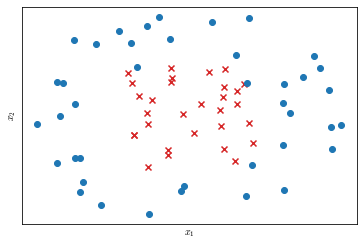

In [3]:
fig, ax = plt.subplots()
ax.scatter(*random_points_ellipse(.5, .25, 30), marker='x', c='C3')
ax.scatter(*random_points_ellipse(.5, .25, 40, .8))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

<i id="ellipserandom">Non linear data scattered on its features space $(x_1, x_2)$. In this plots coordinates are randomly generated to fill two ellipses.</i>

We could manually design an hypothesis with high order polynomial features to model the data, but is there a better way to choose the features?

## Kernels
In this section we will start to explore the idea of **kernels** to define new features. 

Let's manually choose three points in the feature space $(x_1, x_2)$, that we will call the **landmarks** $l^{(1)}, l^{(2)}, l^{(3)}$ (<a href="#manuallandmarks">figure below</a>). We are going to define our as a measure of similarity between the training examples and the landmarks.

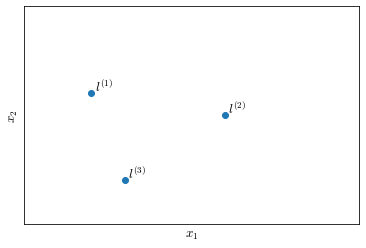

In [6]:
a = np.array([[0.20, 0.60],
              [0.60, 0.50],
              [0.30, 0.20]])

fig, ax = plt.subplots()
ax.scatter(*a.T)
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
for i, p in enumerate(a, 1):
    ax.text(*p + .01, '$l^{{({})}}$'.format(i), fontsize=13)

<i id="manuallandmarks">Three landmarks points chosen manually</i>

Given an example $x$, we will define three features $f_1, f_2, f_3$:

$$
\begin{align}
& f_1 = k(x, l^{(1)}) = \exp\left({-\frac{\| x - l^{(1)}\|^2}{2 \sigma^2}}\right) \\
& f_2 = k(x, l^{(2)}) = \exp\left({-\frac{\| x - l^{(2)}\|^2}{2 \sigma^2}}\right) \\
& f_3 = k(x, l^{(3)}) = \exp\left({-\frac{\| x - l^{(3)}\|^2}{2 \sigma^2}}\right)
\end{align}
$$

where $k$ stands for kernel and is a function that measure similarity and $\| x - l^{(i)}\|$ is the euclidean distance between the example $x$ and the landmark point $l^{(i)}$. In particular the specific kernel $k$ used here is called the **Gaussian kernel**.

Let's explore more in detail the first landmark, whose numerator can be also written as the square of the component-wise distance of the vector $x$ from the vector $l^{(1)}$:

$$f_1=k\left( x, l^{(i)}  \right) = \exp \left( -\frac{\left \| x - l^{(1)} \right \|^2}{2\sigma^2}\right) = \exp \left( -\frac{\sum_{j=1}^n \left(x_j-l_j^{(1)} \right)^2}{2\sigma^2} \right)$$

When $x \approx l^{(1)}$, the euclidean distance between $x$ and $l^{(1)}$ will be $\approx 0$ and $f_1 \approx 1$ 

$$
f_1 \approx \exp \left ( - \frac{0^2}{2 \sigma^2} \right ) \approx 1 
$$

Conversely, when $x$ is far from $l^{(1)}$ the euclidean distance between $x$ and $l^{(1)}$ will be a large number and $f_1 \approx 0$

$$
f_1 = \exp \left( - \frac{\text{large number}^2}{2 \sigma^2} \right) \approx 0
$$

To summarize:

$$
f_1 \approx
\begin{cases}
1 & \text{if } x \approx l^{(1)} \\
0 & \text{if } x \neq l^{(1)}
\end{cases}
$$

Since we have three landmark points $l^{(1)}, l^{(2)}, l^{(3)}$, given an example $x$ we can define three new features $f_1, f_2, f_3$.

### Similarity function
Let's take a look at the similarity function $k$. Suppose 

$$
l^{(1)} = \begin{bmatrix}3\\5\end{bmatrix}, \quad f_1 = \exp \left( -\frac{\left \| x - l^{(1)} \right \|^2}{2\sigma^2}\right)
$$

By looking at <a href="#gaussk">the figure below</a>, we can see how $f_1 \to 1$ when $x_1 \to 3$ and $x_2 \to 5$, where $(3, 5)$ are the coordinates of $l^{(1)}$. 

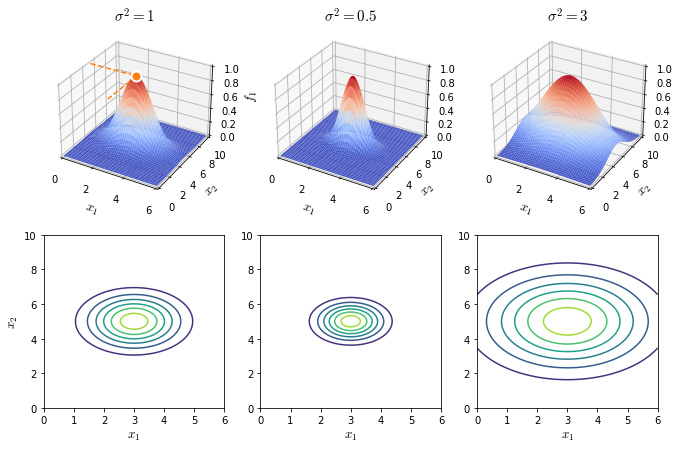

In [39]:
l = np.array([3, 5])
# meshgrid on range 0:6 and 0:10
x, y = np.mgrid[0:6:100j, 0:10:100j]
# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])

# define f_1
f1 = lambda dist, sigma2: np.exp((-dist**2)/(2*sigma2))
# calculate euclidean distance x - l
# https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
euclidean_distance = abs(np.linalg.norm(xy-l, axis=1))


# make plot
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(231, projection='3d')
z = f1(euclidean_distance, 1).reshape(x.shape)
ax.plot_surface(x, y, z,
                cmap='coolwarm', zorder=0)
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13)
ax.set_zlabel('$f_1$', fontsize=13)
ax.set_xlim(0, 6)
ax.set_ylim(0, 10)
ax.set_zlim(0, 1)
ax.set_title('$\\sigma^2=1$', fontsize=15)
ax.plot([0, 3, 3], [5, 5, 0], [1, 1, 1], markersize=10, marker='o', zorder=10, c='C1', ls='--', 
        markevery=[1], markeredgecolor='w', markeredgewidth=2)
ax = fig.add_subplot(234)
ax.contour(x, y, z)
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13)
ax = fig.add_subplot(232, projection='3d')
z = f1(euclidean_distance, .5).reshape(x.shape)
ax.plot_surface(x, y, z,
                cmap='coolwarm', zorder=0)
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13)
ax.set_xlim(0, 6)
ax.set_ylim(0, 10)
ax.set_zlim(0, 1)
ax.set_title('$\\sigma^2=0.5$', fontsize=15)
ax = fig.add_subplot(235)
ax.contour(x, y, z)
ax.set_xlabel('$x_1$', fontsize=13)
ax = fig.add_subplot(233, projection='3d')
z = f1(euclidean_distance, 3).reshape(x.shape)
ax.plot_surface(x, y, z,
                cmap='coolwarm', zorder=0)
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13)
ax.set_xlim(0, 6)
ax.set_ylim(0, 10)
ax.set_zlim(0, 1)
ax.set_title('$\\sigma^2=3$', fontsize=15)
ax = fig.add_subplot(236)
ax.contour(x, y, z)
ax.set_xlabel('$x_1$', fontsize=13);

<i id="gaussk">Three-dimensional surface and contour plot of the value the gaussian kernel $f_1$ as a function of the features $x_1$ and $x_2$. The three couple of plots are views of the kernel values when $\sigma^2= 1, 0.5, 3$ respectively.</i>

It is also interesting to notice the effect of different values of $\sigma^2$ on $f_1$ output. When $\sigma^2$ decreases, $f_1$ falls to $0$ much more rapidly when $x$ stray from $l^{(1)}$. Conversely if the value of $\sigma^2$ is large the decay of $f_1$ is much slower.

### Multiple landmarks
Let's get back to <a href="#manuallandmarks">the figure with the manually set landmarks</a> and let's try to put together what we have learned in the case of multiple landmarks.

We have three features $f_1, f_2, f_3$ and our hypothesis:

$$
y = 1 \quad \text{if} \quad \theta_0 + \theta_1f_1 + \theta_2f_2 + \theta_3f_3 \geq 0
$$

Suppose that we have run our learning algorithm and came up with the following parameters

$$
\theta=
\begin{bmatrix}
0.5 \\ 1 \\ 1 \\ 0
\end{bmatrix}
$$

Now let's consider various training examples placed on the features space $(x_1, x_2)$ represented on <a href="#manuallandmarks2">the figure below</a>.

Training example $x^{(1)}$ is close to $l^{(1)}$, hence $f_1 \approx 1$ while $f_2, f_3 \approx 0$. Its prediction will be:

$$
\begin{align}
h_\theta(x^{(1)}) & =  \theta_0 + \theta_1 \cdot 1 + \theta_2 \cdot 0 + \theta_3 \cdot 0 \\
&= -0.5 + 1 \\
&= 0.5 \geq 1 \\
& \to y^{(1)} = 1  
\end{align}
$$


Training example $x^{(2)}$ is far from any landmark, hence $f_1, f_2, f_3 \approx 0$ and $y^{(2)} \approx -0.5$



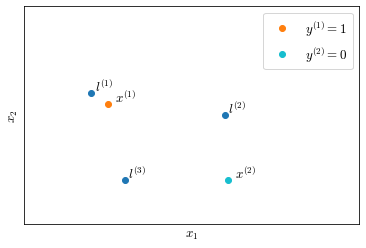

In [34]:
fig, ax = plt.subplots()
ax.scatter(*a.T)
ax.set_xlabel('$x_1$', fontsize=13)
ax.set_ylabel('$x_2$', fontsize=13)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
for i, p in enumerate(a, 1):
    ax.text(*p + .01, '$l^{{({})}}$'.format(i), fontsize=13)

ax.plot(*a[0] + [.05, -.05], ls='none', marker='o', c='C1', label='$y^{(1)}=1$')
ax.text(*a[0] + [.07, -.04], '$x^{(1)}$', fontsize=13)
ax.plot(*a[1] + [.01, -.3], ls='none', marker='o', c='C9', label='$y^{(2)}=0$')
ax.text(*a[1] + [.03, -.29], '$x^{(2)}$', fontsize=13)
ax.legend(fontsize=13);

<i id="manuallandmarks2">Manually placed landmarks as in <a href="#manuallandmarks">previous figure</a> and training example falling close or far from landmarks.</i>

### Choice of the landmarks
Until now we manually picked the landmarks, in an SVM landmarks are defined as exactly the same coordinates as the points in the training set. This means that when an input is fed to the trained algorithm, it calculates how close it is to points in the training set.

### SVM with kernels
By defining the landmarks as the example coordinates means that if we have an $m \times n$ training set where each example $x^{(i)} \in \mathbb{R}^{n+1}$ space, we are going to define $m$ features (one for each training example), so that we will have our feature vector $f \in \mathbb{R}^{m+1}$ and also our parameter vector $\theta \in \mathbb{R}^{m+1}$.

The training for an SVM with kernels will be

$$
\min_\theta C \sum^m_{i=1}y^{(i)} \text{cost}_1  \underbrace{\left(\theta^T f^{(i)}\right)}_{ \neq \theta^Tx^{(i)}}  + \left( 1- y^{(i)}\right) \text{cost}_0 \left( \theta^T f^{(i)}\right) + \frac{1}{2} \sum^{\overbrace{n}^{m}}_{j=1}\theta^2_j
$$


#### Implementation detail of SVM optimization
In optimization implementations, usually the term $\sum^{\overbrace{n}^{m}}_{j=1}\theta^2_j$ is calculated as $\theta^T\theta$. 

When optimizing an SVM algorithm, since $\theta \in \mathbb{R}^{m+1}$, we could end up with a huge number of parameters and $\theta^T\theta$ becomes inefficient or computationally impossible. 

For this reason the term is usually slightly changed to $\theta^TM\theta$, where $M$ is a matrix that makes the computation much easier.

Incidentally, this implementation trick is also what prevents the kernel strategy to be applied to other learning algorithms. Kernels can be used with logistic regression too, however the $\theta^TM\theta$ would not be as useful as with SVMs, and consequently computation would not scale with the number of examples.

### SVM hyper-parameters
There are two parameters that need to be manually set for SVMs and will affect the bias *vs* variance trade-off: $C$ and $\sigma^2$

$C \approx \frac{1}{\lambda}$:

* large $C$: Lower bias, higher variance
* small $C$: Higher bias, lower variance

$\sigma^2$, as we can infer from <a href="#gaussk">the figure with the gaussian and contour plots</a>:

* Large $\sigma^2$: features $f_i$ vary more smoothly; higher bias, lower variance
* Small $\sigma^2$: features $f_i$ vary more abruptly; lower bias, higher variance